In [1]:
import math
import copy
from task import Task
from caseLoader import CaseLoader
from taskType import TaskType
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
MT = 10 # microtick

In [3]:
loader = CaseLoader()
cases = loader.load_test_case("inf_30_30", 0)
cases = [c for c in cases if c.type == TaskType.TIME]

Searching for test cases at:
./test_cases/inf_30_30
Loaded case_group: inf_30_30 - case: 0 test case(s).


In [4]:
def get_ready(task_set, cycle, ready_list):
    for task in task_set:
        if cycle % task.period == 0:
            new_job = copy.deepcopy(task)
            new_job.deadline = new_job.deadline + cycle
            new_job.release_time = cycle
            ready_list.append(new_job)
    
    # sort on deadline
    # https://www.geeksforgeeks.org/sorting-objects-of-user-defined-class-in-python/
    ready_list = sorted(ready_list, key=lambda t: t.deadline) 
    
    return ready_list
        

# ts is set of TT tasks
def edf(ts):
    T = math.lcm(2000,3000,4000) # least common multiple of TT task periods. 2000 mt = 
    S = [] # schedule will be hyperperiod long. 12 000 microticks == 120 000 microsecs == 120 ms
    ready_list = []
    wcrts = {} # worst case response times
    
    # overvej reset funktioner i task klassen istedet for alle de kopier...
    for t in range(0, T):
        ready_list = get_ready(ts, t, ready_list)
        
        for task in ready_list:
            if task.duration > 0 and task.deadline <= t:
                return [], -1
        
            # job done check response time gt wcrt and remove from ready list
            if task.duration == 0 and task.deadline >= t:
                response_time = t - task.release_time
                
                if task.name not in wcrts or response_time >= wcrts[task.name]:
                    wcrts[task.name] = response_time
                
                ready_list.remove(task)
                
            
        if ready_list == []:
            S.append("IDLE")
            continue
        else:
            # EDF get next job to execute 
            S.append(ready_list[0].name)
            ready_list[0].duration = ready_list[0].duration - 1
    
    if ready_list != []:
        return [], wcrts
    
    return S, wcrts

In [5]:
s, wcrts = edf(cases)

In [6]:
print(sum([wcrts[key] for key in wcrts]))

11843


In [7]:
"""
Determine: You will have to design and implement an optimization algorithm that
determines an optimized solution which consists of the following: (i) The number of polling
servers, which then become extra TT tasks. (ii) For each polling server (task), the period,
budget, and deadline, as well as (iii) which sub-sets of ET tasks are handled within the
respective polling servers. Moreover, the TT tasks also need to be schedulable, i.e., given the
found polling tasks (and their parameters), it shall be possible to find (iv) a TT schedule
such that also the TT tasks are schedulable

"""

NUM_PS = 0
BUDGET = 1
PERIOD = 2
DEADLINE = 3
SUBSET = 4

# get a subset of pses from victim and delete these from victim
# -1 to not steal all, max (1, otherthing) to not get rand(1, -x)
def get_subset(s, victim_ps):
    num_et_tasks = rand.randint(1, max(1, len(victim_ps.et_subset) - 1)) 
    new_ps_et_subset = []
        
    for task in victim_ps.et_subset[0:num_et_tasks]:
        new_ps_et_subset.append(task)
        victim_ps.et_subset.remove(task)
        
    return new_ps_et_subset
    
# take polling servers as arg, 
def neighborhood(polling_servers):
    # select randomly a ps then randomly choose to change:
        # num_ps, period, budget, deadline or subset of et_tasks
        # et_tasks will have to take some from another/give 
        # do not worry whether newly generated solution is feasible 
        # return new solution 
    
    # num_ps, period, budget, deadline, subset
    
    # select parameter to change   
    parameter = rand.randint(0, 4)
    
    # sel
    victim_ps = polling_servers[rand.randint(0,len(polling_servers)) % len(polling_servers)] # victim to change etc.
    
    # increase or decrease chosen parameter
    sign = 1 if rand.randint(0,1) == 0 else -1
    
    # only adds a polling server. add functionality to remove one and move et subset to other ps
    if parameter == NUM_PS:
        new_ps_et_subset = get_subset(polling_servers, victim_ps)
        new_ps = Task("tTT" + str(rand.randint(0,5000)), 1000, 1000, TaskType.TIME, 7, 1000, new_ps_et_subset)
        
        return polling_servers + [new_ps]
    
    elif parameter == BUDGET:
        victim_ps.duration = max(50, victim_ps.duration + sign * 50)
        victim_ps.duration = 1 if victim_ps.duration == 0 else victim_ps.duration
    elif parameter == PERIOD:
        victim_ps.period = max(50, victim_ps.period + sign * 50)
        victim_ps.period = 1 if victim_ps.period == 0 else victim_ps.period
    elif parameter == DEADLINE:
        victim_ps.deadline = max(50, victim_ps.deadline + sign * 50)
    elif parameter == SUBSET:
        if len(polling_servers) == 1: # if no one to steal from 
            return polling_servers 
        other_ps_victim = polling_servers[rand.randint(0, len(polling_servers)) % len(polling_servers)]

        while other_ps_victim == victim_ps:
            other_ps_victim_i = polling_servers[rand.randint(0, len(polling_servers)) % len(polling_servers)]
            
        new_ps_et_subset = get_subset(polling_servers, other_ps_victim)
        
        victim_ps.et_subset += new_ps_et_subset
        
    return polling_servers

In [8]:

rand = random.Random()
    
def p(delta, t):
    return np.exp( -delta / t )

# simulated annealing 
def sa(s0, t, a, stopcriterion_sec, neighborhood_f = None, cost_f1=None, cost_f2=None, log_costs = False):
    # initialize variables
    sec0 = int(time.time())
    sec_now = int(time.time())
    
    # get tt and et tasks
    tt = [t for t in s0 if t.type == TaskType.TIME]
    et = [t for t in s0 if t.type == TaskType.EVENT]
    
    # initialize a single polling server
    polling_servers = [Task("tTTps00", 1000, 1000, TaskType.TIME, 7, 1000, et_subset=et[:])]
    
    # best solution
    s_best = []
    cost_best = float('inf') # hmm :)
    best_ps_config = []

    # current solution, used in loop
    s_cur = tt[:]
    cost_cur = float('inf')
    
    # 1 entry pr. cycle in hyperperiod
    schedule = []
    
    # for logging purposes
    n_solutions = 0
    cost_log = []
    
    # does not matter if < or <= if 0 then new solution will be selected no matter what     
    while sec_now - sec0 < stopcriterion_sec:
        ps_tmp = neighborhood_f(polling_servers)
        
        # https://www.geeksforgeeks.org/reduce-in-python/
        # create list of bools by applying schedulability check for ets, fold into single bool using and.
        is_schedulable = reduce((lambda a, b : a and b), [cost_f2(ps, ps.et_subset) for ps in ps_tmp])
        
        # if not schedulable skip iteration
        if not is_schedulable:
            continue 
        
        # get schedule and wcrts of each tt
        schedule_tmp, cost_tmp_dict = cost_f1(tt + ps_tmp)
        
        # -1 returned in case not schedulable
        if cost_tmp_dict == -1:
            continue
        
        # add wcrts... might wanna reconsider this
        cost_tmp = sum([cost_tmp_dict[key] for key in cost_tmp_dict])
        
        delta = cost_tmp - cost_cur
        
        # accept randomly drawn solution from current neighborhood if better or with some probability
        if delta <= 0 or p(delta, t) > rand.uniform(0.0, 1.0):
            s_cur = tt + ps_tmp # update current solution, current set of polling servers, costs & schedule
            polling_servers = ps_tmp[:] # all these copies...
            cost_cur = cost_tmp
            schedule = schedule_tmp[:]
            
            if log_costs: # logging
                cost_log.append(cost_cur)
            
            # keep track of the best solution 
            if cost_cur < cost_best:
                s_best = s_cur
                best_schedule = schedule[:]
                cost_best = cost_cur
                best_ps_config = polling_servers
                        
        # update temperature 
        t = t * a
        
        n_solutions = n_solutions + 1
        
        # update sec
        sec_now = int(time.time())
        
    return (schedule, cost_best, cost_log, best_ps_config) if log_costs else (schedule, cost_best, best_ps,config) 
    

In [9]:
def unpack(task):
    return (task.priority, task.duration, task.period, task.deadline)

#Schedulability of ET tasks under a given polling task
def calculate_schedulabiltiy(ps, task_periods):
    Tp = ps.period
    Dp = ps.deadline
    Cp = ps.duration
    
    #compute delta and alpha accordingly to [2]
    Delta = Tp + Dp - 2*Cp
    alpha = Cp/Tp
    
    #hyperperiod is lcm of all task periods in T_ET (all values must be from the chosen subset of ET tasks from the .csv)
    periods = []
    for task in task_periods:
        (pi, Ci, Ti, Di) = unpack(task)
        periods.append(Ti)

    hyperperiod = math.lcm(*periods)    

    #loop
    for task_period in task_periods:
        (pi, Ci, Ti, Di) = unpack(task_period)
        t = 0
        #initialize the response time of ti (task period) to a value exceeding the deadline
        response_time = Di + 1

        #remember we are dealing with constrained deadline tasks for the AdvPoll, hence, in the worst case arrival pattern, the intersection must lie within the hyperperiod if the task is schedulable

        while t <= hyperperiod:
            #the supply at time t ([1])
            supply = alpha*(t-Delta)

            #compute the maximum demand at time t according to Eq. 2
            demand = 0
            for tj in task_periods:
                (pj, Cj, Tj, Dj) = unpack(tj)

                if pj >= pi:
                    demand  = demand + math.ceil(t/Tj)*Cj
            
            #According to lemma 1 of [1], we are searching for the earliest time, when the supply exceeds the demand
            if supply >= demand:
                response_time = t
                break
            
            t = t + 1
        
        if response_time > Di:
            return False
        
    return True


In [10]:
loader = CaseLoader()
tasks = loader.load_test_case("inf_30_30", 0)

Searching for test cases at:
./test_cases/inf_30_30
Loaded case_group: inf_30_30 - case: 0 test case(s).


In [11]:
schedule, cost_best, cost_log, best_ps_config = sa(tasks, 1000, .99, 60, neighborhood_f = neighborhood, cost_f1=edf, cost_f2=calculate_schedulabiltiy, log_costs=True)

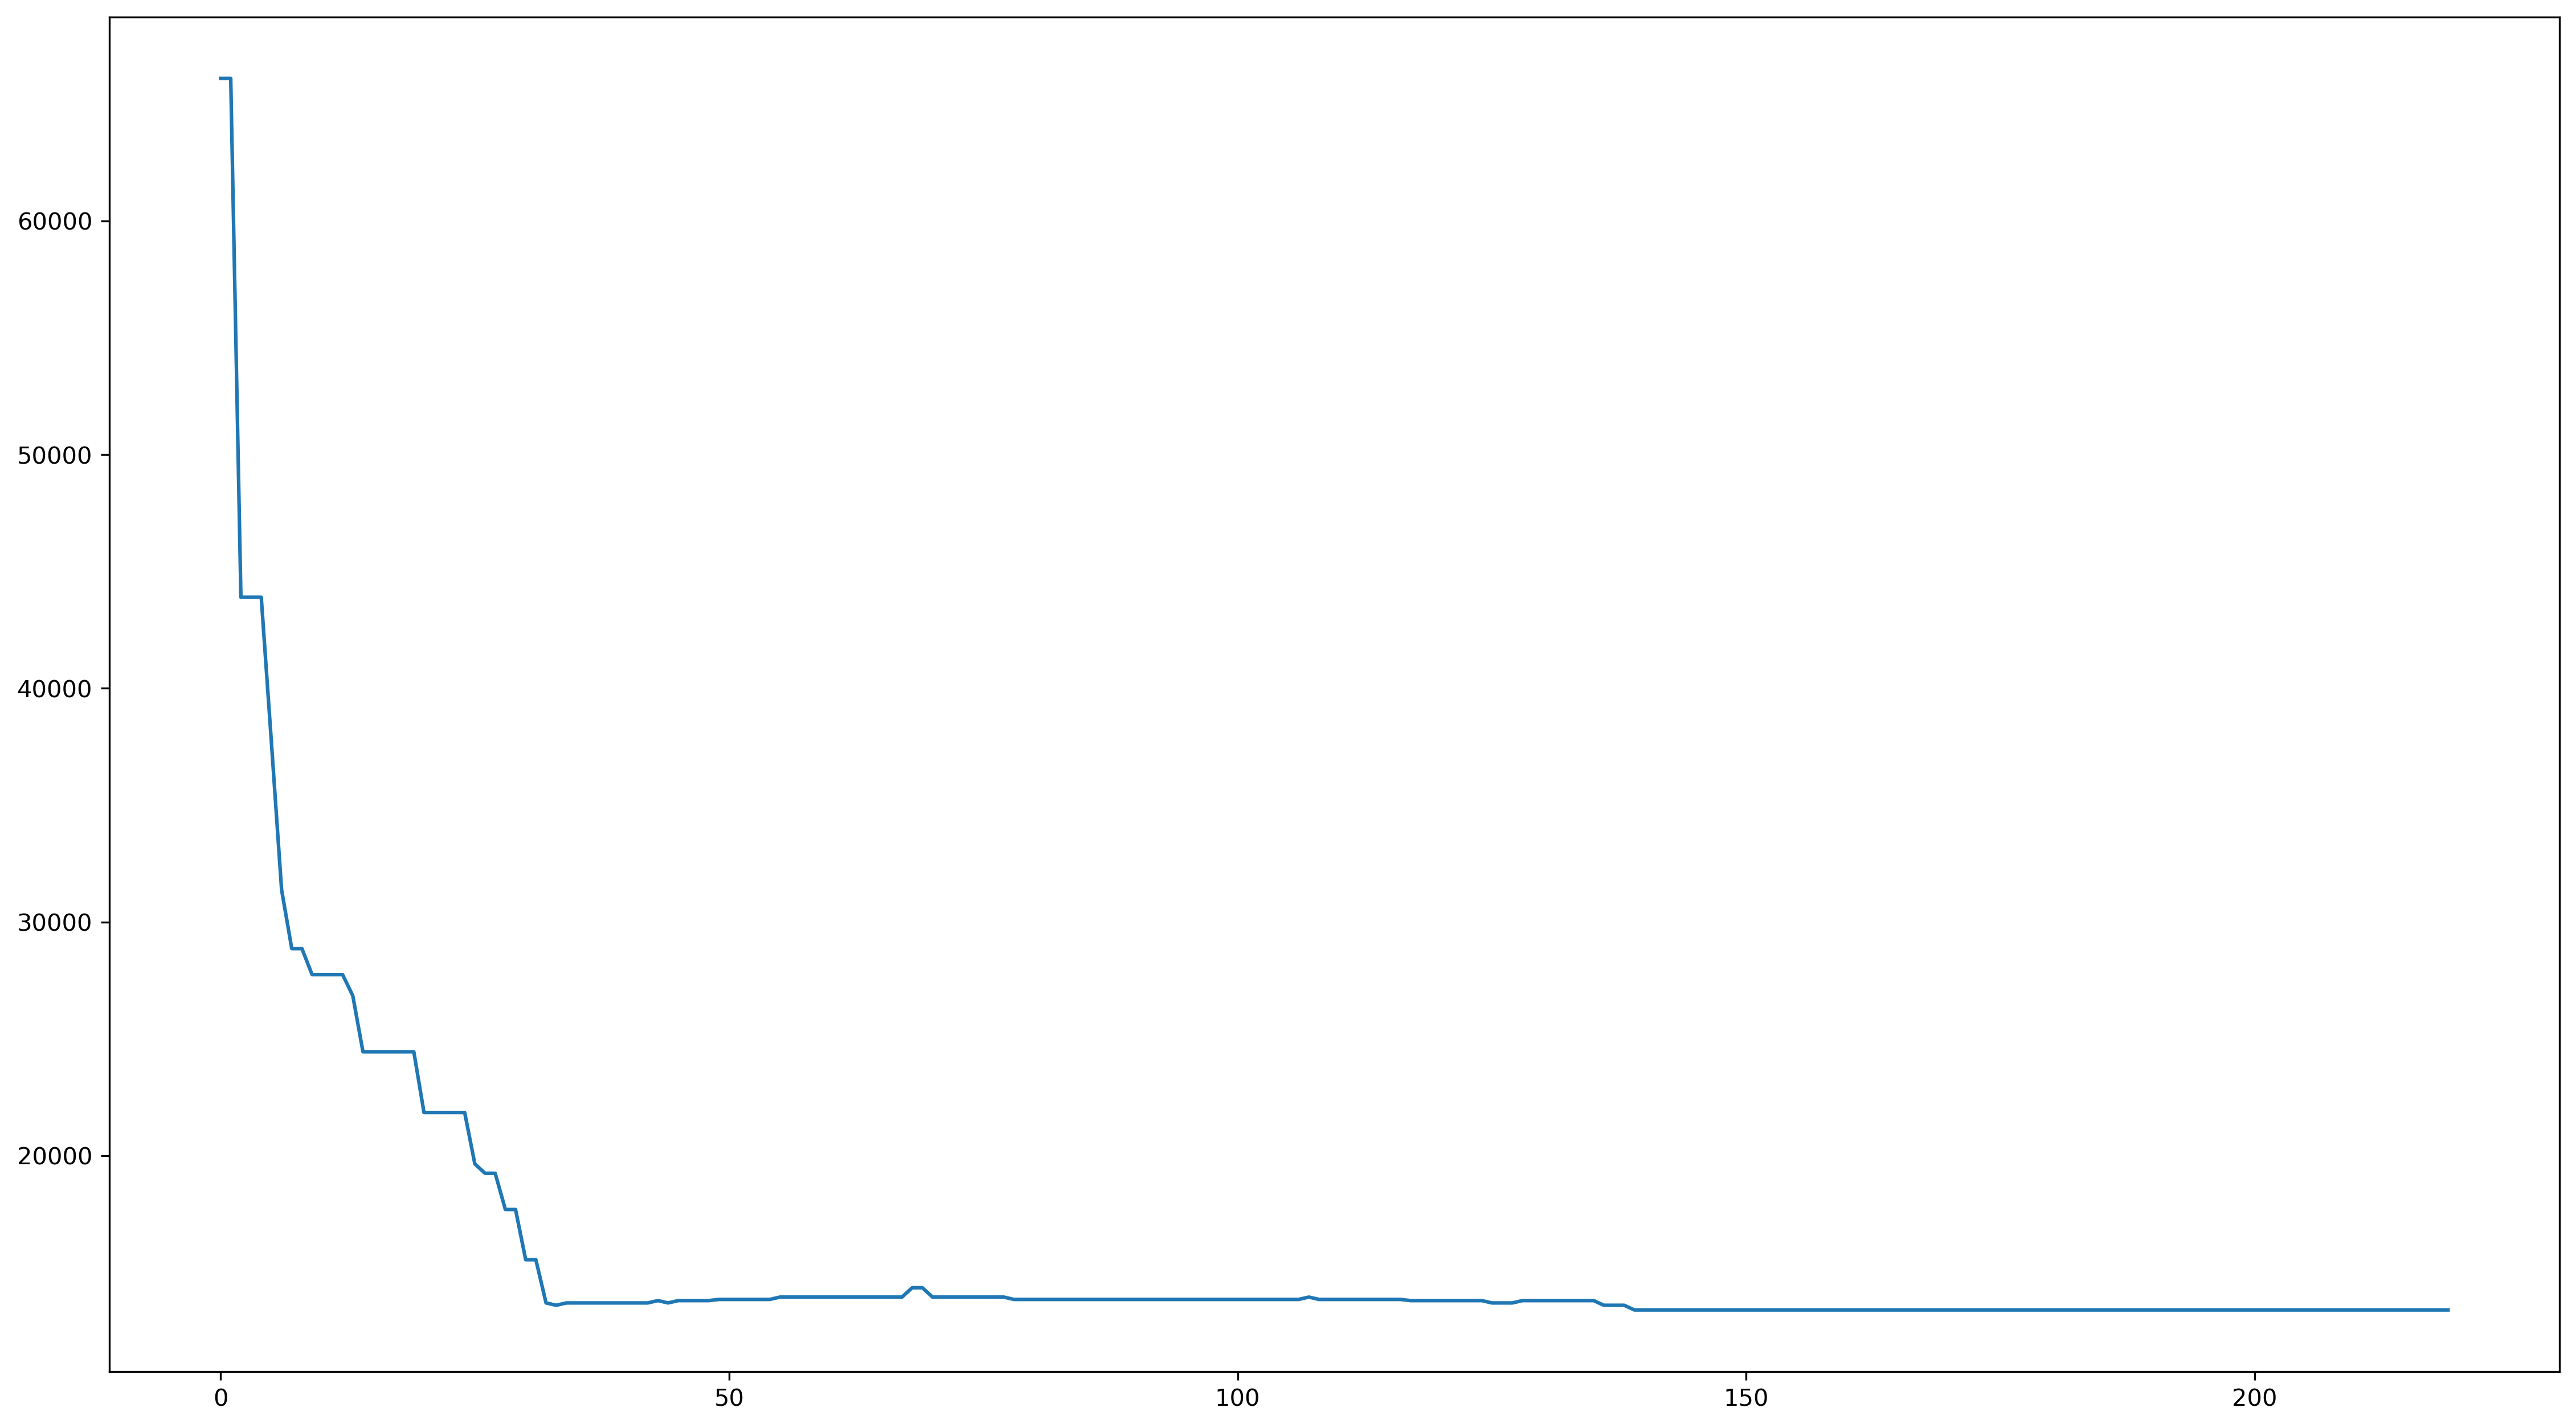

In [12]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cost_log)), cost_log)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(300)

In [13]:
print(cost_best)

13393


In [14]:
print(sum([1 for t in schedule if t == "tTTps00"]))

500


In [15]:
l = [True, True, False]

sum([e.duration for e in tasks if e.type == TaskType.EVENT])

904

In [16]:
(lambda x : x + 1)(-1)

0

In [17]:
print(cost_best)

13393


In [18]:
for ps in best_ps_config:
    print(ps.name, ps.deadline, ps.duration, ps.period)

tTTps00 750 400 1750


In [19]:
reduce((lambda a, b : a and b), [True, False, True, True])

False

In [20]:
a = Task("a",1,2,3,3,3)
b = Task("a",1,2,3,3,5)
l = [a,b]
for t in l:
    print(t.deadline)


c = l[0]
c.deadline = 1000
for t in l:
    print(t.deadline)

3
5
1000
5


In [21]:
int(12000 / 2600)

4

In [22]:
10 * 650

6500

In [23]:
rand.randint(0,4)

2

In [24]:
s = "LALA"


SyntaxError: invalid syntax (2425687908.py, line 1)